In [2]:
import os
import sys
import copy
import socket
import pickle
import importlib
import itertools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
sys.path.append(os.path.join(SRC_DIR, "models"))
import data_loader
import model_utils
import recurrent
import plotting_utils
import basset_family
import interpretation
import seq
import pwm
import utils

print(f"Torch version: {torch.__version__}")
if torch.cuda.is_available():
    DEVICE = utils.get_device(-2)
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("CPU")
    DEVICE = torch.device("cpu")

np.random.seed(27492)
SEED = 27492

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492
K_FOLD = 5

Torch version: 1.4.0
CUDA version: 10.1


In [4]:
importlib.reload(data_loader)
lstm_train_dataset = data_loader.LocalizationClassificationIdxUntrimmed("train", k_fold=K_FOLD, addtl_negatives=False)
lstm_valid_dataset = data_loader.LocalizationClassificationIdxUntrimmed("valid", k_fold=K_FOLD, addtl_negatives=False)
lstm_test_dataset = data_loader.LocalizationClassificationIdxUntrimmed("test", k_fold=K_FOLD, addtl_negatives=False)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [7]:
importlib.reload(model_utils)
importlib.reload(recurrent)
importlib.reload(utils)

def lstm_train(model, train_dataset, valid_dataset, lr=1e-3, optim=torch.optim.SGD, num_epochs=30, examples_per_epoch=None, early_stop_patience=5, progressbar=True, device=DEVICE):
    """Train the LSTM"""
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Input of logits, model should not run sigmoid
    optimizer = optim(model.parameters(), lr=lr)
    assert early_stop_patience > 0
    early_stopper = model_utils.EarlyStopper(patience=early_stop_patience, verbose=True)

    np.random.seed(1234)
    retval = []  # Return a list of epoch state dicts
    for epoch in range(num_epochs):
        n = len(train_dataset) if examples_per_epoch is None else examples_per_epoch
        indices = np.random.choice(np.arange(len(train_dataset)), size=n, replace=False)  # No replacement
        for i in tqdm.notebook.tqdm(indices, desc=f"Epoch {epoch}", disable=not progressbar):  # For quick debugging
            x, y = train_dataset[i]
            x = x.type(torch.LongTensor).to(device)
            y = torch.squeeze(y.to(device))

            model.zero_grad()
            model_out = model(x)
            loss = criterion(model_out, y)
            loss.backward(retain_graph=True)
            optimizer.step()

        epoch_perf, _epoch_per_task_perf, _truths, _preds = lstm_eval(model, valid_dataset)
        print(f"Epoch {epoch}: {epoch_perf.auroc} | {epoch_perf.auprc}")
        epoch_dict = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(model.state_dict()),
            'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
            'loss': loss,
            'auroc': epoch_perf.auroc,
            'auprc': epoch_perf.auprc,
        }
        retval.append(epoch_dict)
        if early_stopper.record_epoch(epoch_perf):  # Stop if we've gone a set number of epochs without improvement
            break
    return retval

def lstm_eval(net, eval_data, device=DEVICE):
    """Takes a model and a Dataset and evaluates"""
    net.to(device)
    truths, preds = [], []
    with torch.no_grad():
        sig = torch.nn.Sigmoid()  # Assume the model outputs logits
        for i in range(len(eval_data)):  # Causes some weird crashes
            x, y = eval_data[i]
            truths.append(torch.squeeze(y).numpy())
            x, y = x.type(torch.LongTensor).to(device), y.to(device)
            output = net(x)
            output_sig = sig(output)
            preds.append(output_sig.detach().cpu().numpy())
    truths = np.round(np.array(truths)).astype(int)
    preds = np.array(preds).astype(float)
    assert np.all(preds < 1.0) and np.all(preds > 0.0)
    preds = np.squeeze(preds)

    is_multitask = len(truths.shape) > 1 and truths.shape[1] > 1
    overall_retval = model_utils.generate_model_perf(truths, preds, multiclass=is_multitask)
    per_task_retval = model_utils.generate_multiclass_perf(truths, preds, truths.shape[1])

    return overall_retval, per_task_retval, truths, preds

In [8]:
rna_gru = recurrent.GRULocalizationClassifier(32, 64, gru_layers=2, device=DEVICE)
rna_gru_states = lstm_train(rna_gru, lstm_train_dataset, lstm_valid_dataset, num_epochs=30, early_stop_patience=5, optim=torch.optim.Adam, progressbar=False)

Epoch 0: 0.6046648956844232 | 0.24883759963473068
Epoch 1: 0.5967486742891761 | 0.2573204363618855
Epoch 2: 0.6257404763824225 | 0.2750919716021622
Epoch 3: 0.6499432309308955 | 0.2989208258526689
Epoch 4: 0.6472552686925894 | 0.2982441106391299
Epoch 5: 0.6535590954531343 | 0.3091019782459916
Epoch 6: 0.6375552150631503 | 0.2971519428702749
Epoch 7: 0.6568925320717162 | 0.3231259233486818
Epoch 8: 0.6575210066540897 | 0.3181950537501247
Epoch 9: 0.6449847141766925 | 0.31493297935971054
Epoch 10: 0.660445131582576 | 0.3091265221513247
Epoch 11: 0.660929946276833 | 0.3224779205860694
Epoch 12: 0.6480621087244257 | 0.3218752917043117
Epoch 13: 0.6443465868812727 | 0.3065961832530066
Epoch 14: 0.6367410455702451 | 0.2972862648594755
Epoch 15: 0.6374874282071448 | 0.30934896423680097
Epoch 16: 0.652354584245048 | 0.30137492604828575
5 epochs without improvement - sending signal to stop training


In [9]:
rna_gru_aurocs = [s['auroc'] for s in rna_gru_states]

In [10]:
torch.save(rna_gru_states[np.argmax(rna_gru_aurocs)], "gru_double_best.pt")
f"Best validation AUROC: {np.max(rna_gru_aurocs)}"

'Best validation AUROC: 0.660929946276833'

In [18]:
rna_gru_valid_overall_perf, rna_gru_valid_compartment_perf, valid_truths, valid_preds = lstm_eval(rna_gru, lstm_valid_dataset)

In [15]:
# Find youden cutoffs
rna_gru_cutoffs = np.array([model_utils.youden_threshold(valid_preds[:, i], valid_truths[:, i]) for i in range(8)])
np.savetxt("gru_double_valid_cutoffs.txt", rna_gru_cutoffs)
rna_gru_cutoffs

array([0.50846487, 0.23707899, 0.00690271, 0.05880182, 0.47120106,
       0.2661089 , 0.00990488, 0.17354573])

In [19]:
rna_gru_test_overall_perf, rna_gru_test_compartment_perf, test_truths, test_preds = lstm_eval(
    rna_gru,
    lstm_test_dataset,
)

In [27]:
rna_gru_test_overall_perf.auroc, rna_gru_test_overall_perf.auprc

(0.6551892282349736, 0.3219447800654798)

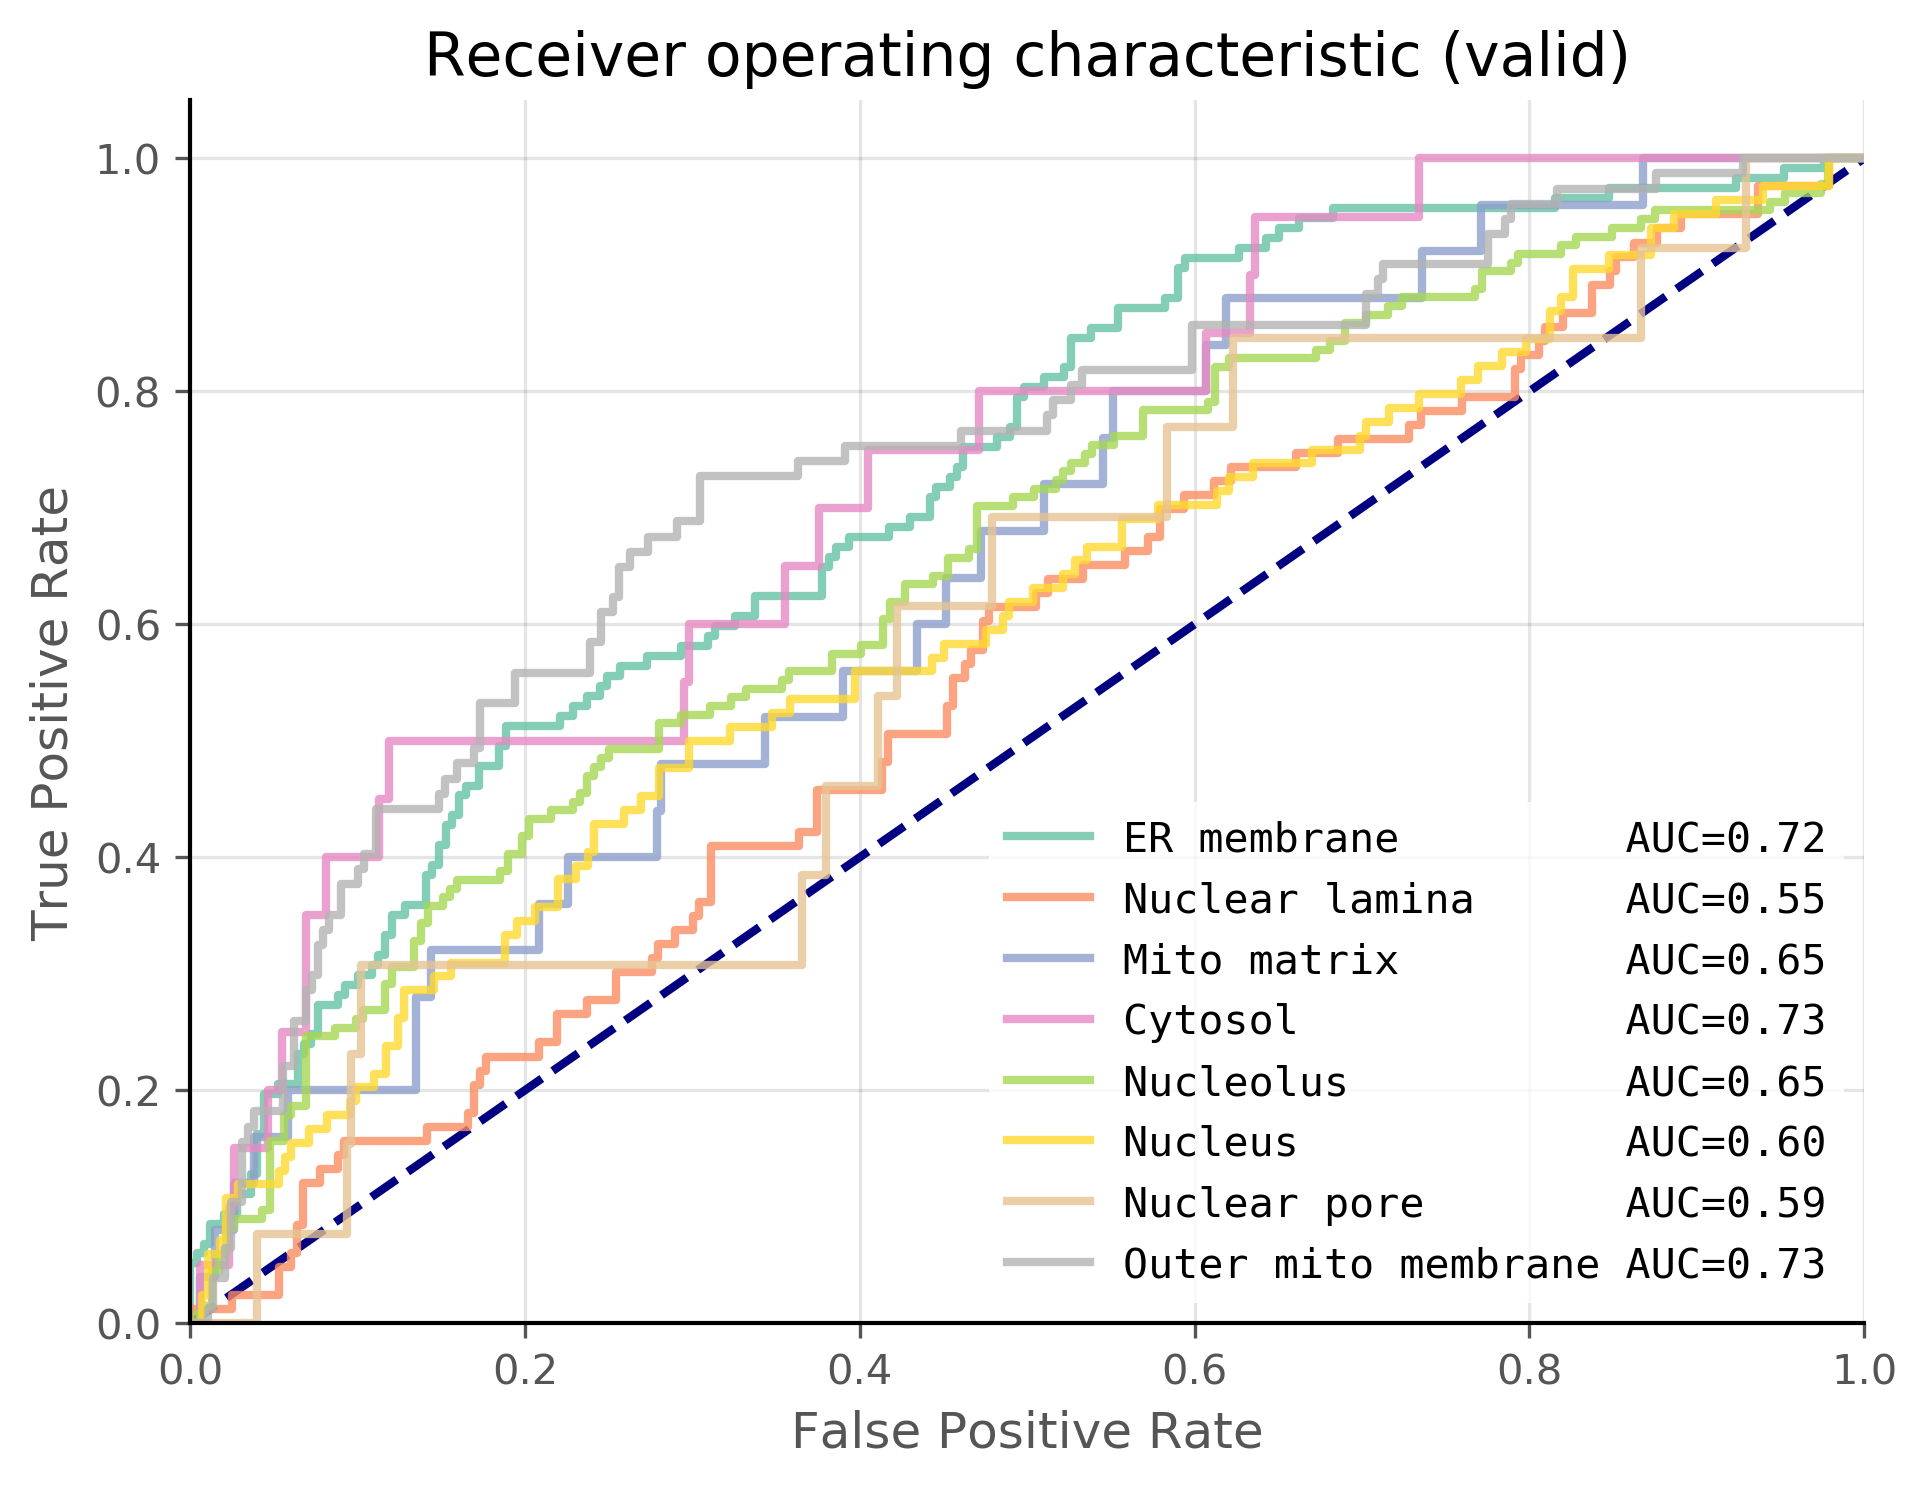

In [34]:
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(lstm_valid_dataset.compartments, rna_gru_valid_compartment_perf)},
    title="Receiver operating characteristic (valid)",
)

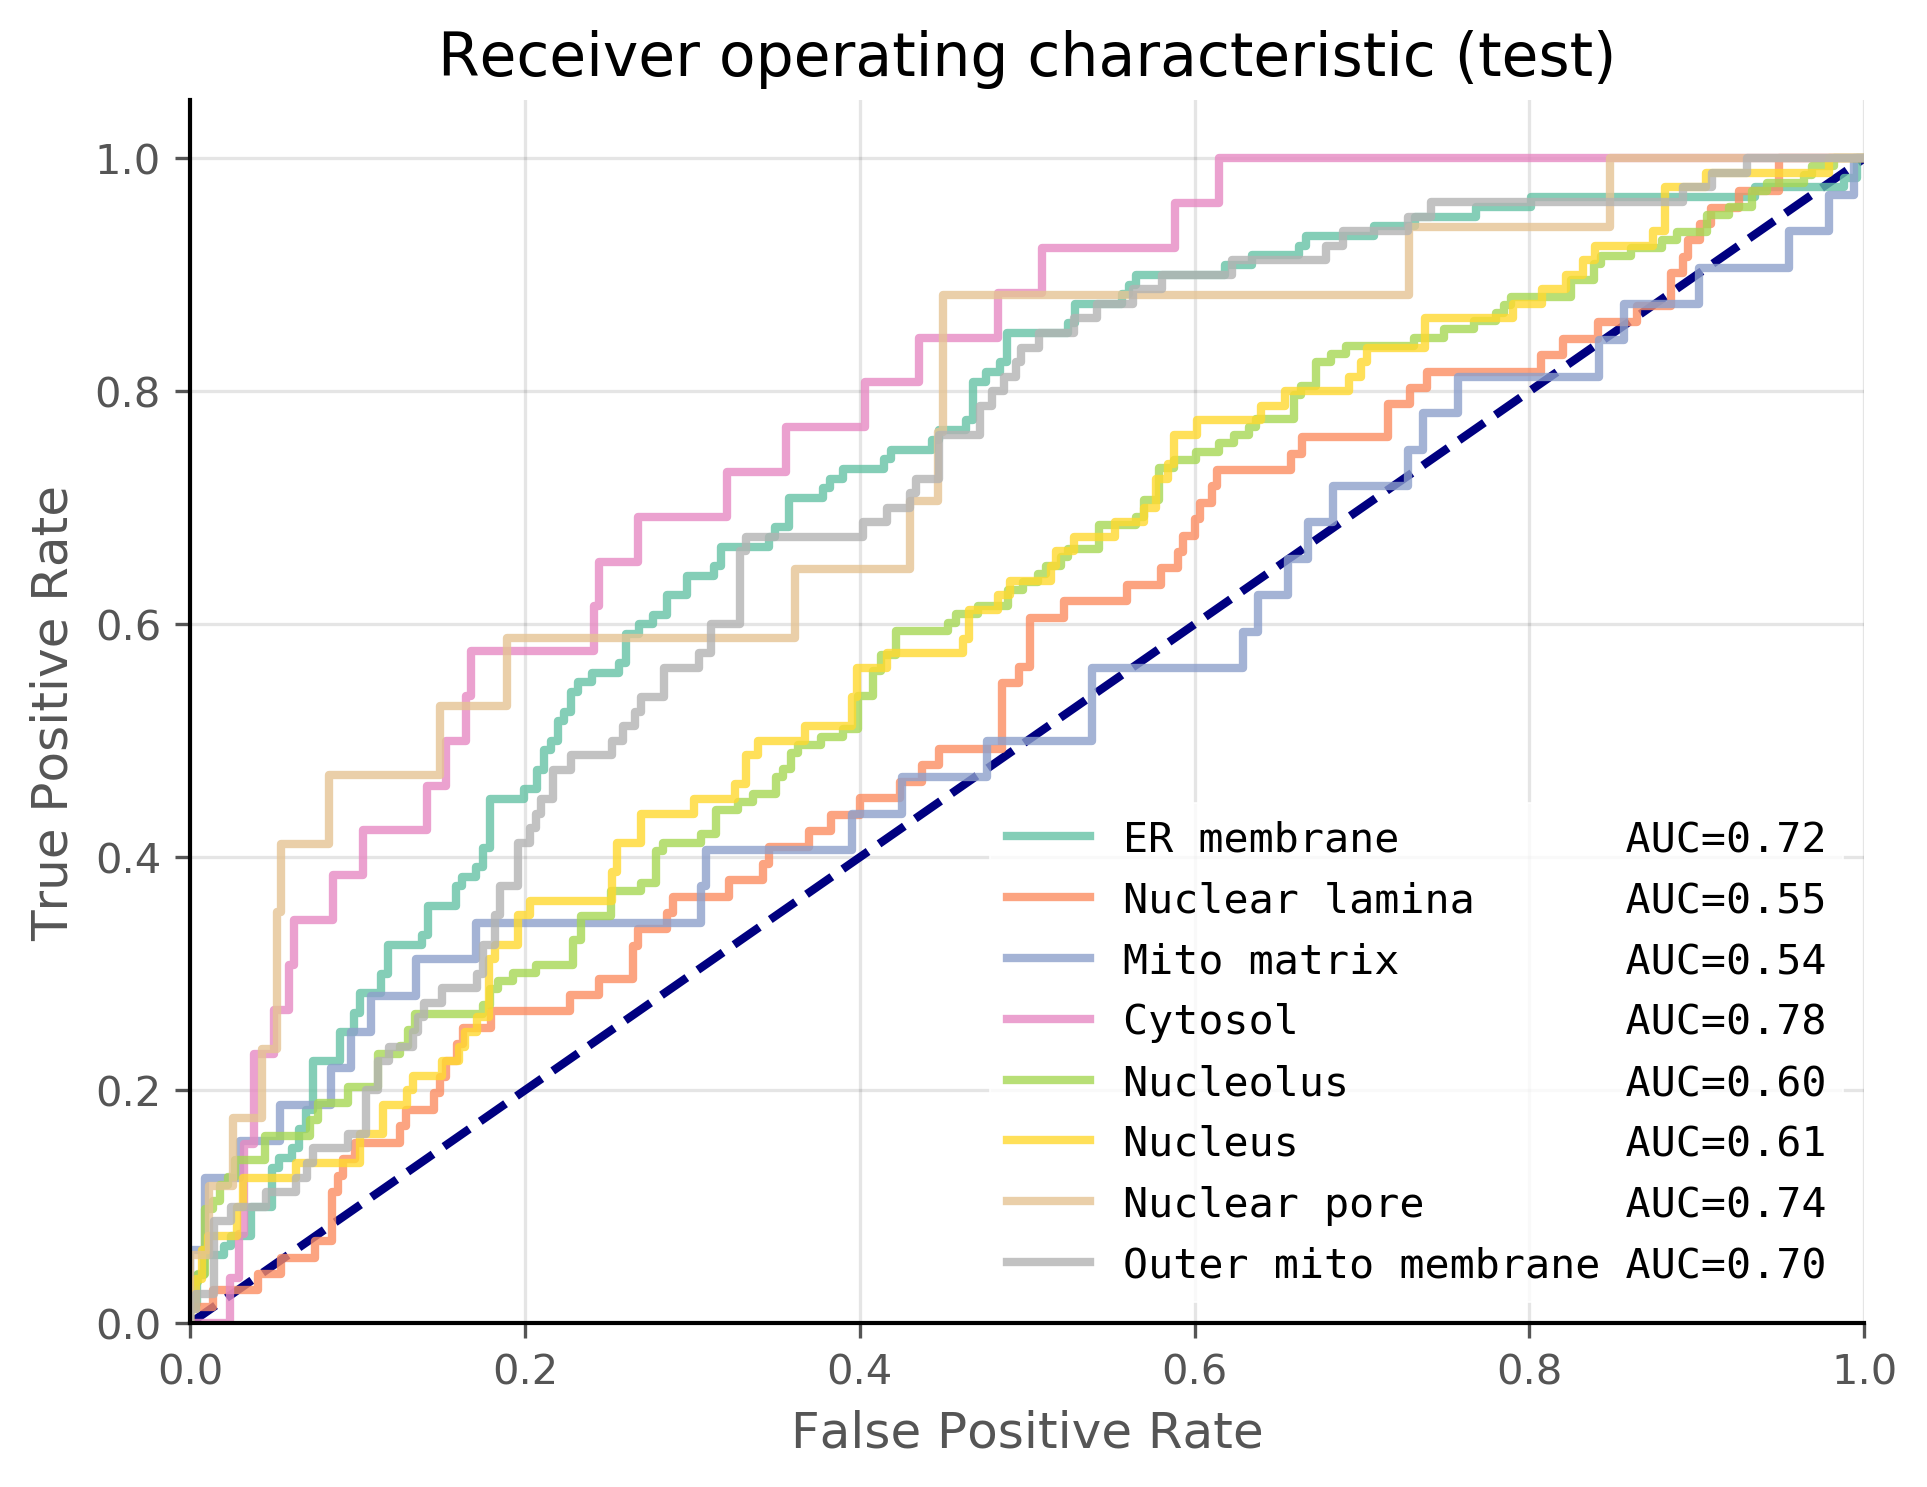

In [33]:
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(lstm_test_dataset.compartments, rna_gru_test_compartment_perf)},
    title="Receiver operating characteristic (test)",
)

In [35]:
baseline_dir = os.path.join(
    os.path.dirname(SRC_DIR),
    "covid19/baselines"
)
assert os.path.isdir(baseline_dir), f"Cannot find {baseline_dir}"
np.savetxt(os.path.join(baseline_dir, "baseline_human_apex_gru.csv"), test_preds)

## Test some other models

In [41]:
importlib.reload(recurrent)
deep_rna_gru = recurrent.DeepGRULocalizationClassifier(32, 64, gru_layers=2, device=DEVICE)
deep_rna_gru_states = lstm_train(deep_rna_gru, lstm_train_dataset, lstm_valid_dataset, num_epochs=30, early_stop_patience=5, optim=torch.optim.Adam, progressbar=False)

Epoch 0: 0.5752593250586219 | 0.2511184496462356
Epoch 1: 0.6154248769488644 | 0.2612780072256612
Epoch 2: 0.6139660249535656 | 0.260387690305553
Epoch 3: 0.6245841291468215 | 0.2710503760671936
Epoch 4: 0.623345775800224 | 0.27050764706868613
Epoch 5: 0.6399664443420771 | 0.2791035778391171
Epoch 6: 0.6059322371114031 | 0.26465943768946265
Epoch 7: 0.6371215726588285 | 0.284546894285685
Epoch 8: 0.6187105371454036 | 0.27463190664680387
Epoch 9: 0.6230132123565257 | 0.28128860203889405
Epoch 10: 0.6235508349549852 | 0.27949494377493395
5 epochs without improvement - sending signal to stop training


In [42]:
deep_rna_gru_test_overall_perf, deep_rna_gru_test_compartment_perf, deep_rna_gru_test_truths, deep_rna_gru_test_preds = lstm_eval(
    deep_rna_gru,
    lstm_test_dataset,
)
deep_rna_gru_test_overall_perf.auroc, deep_rna_gru_test_overall_perf.auprc

(0.6319955029208301, 0.2874419016638943)

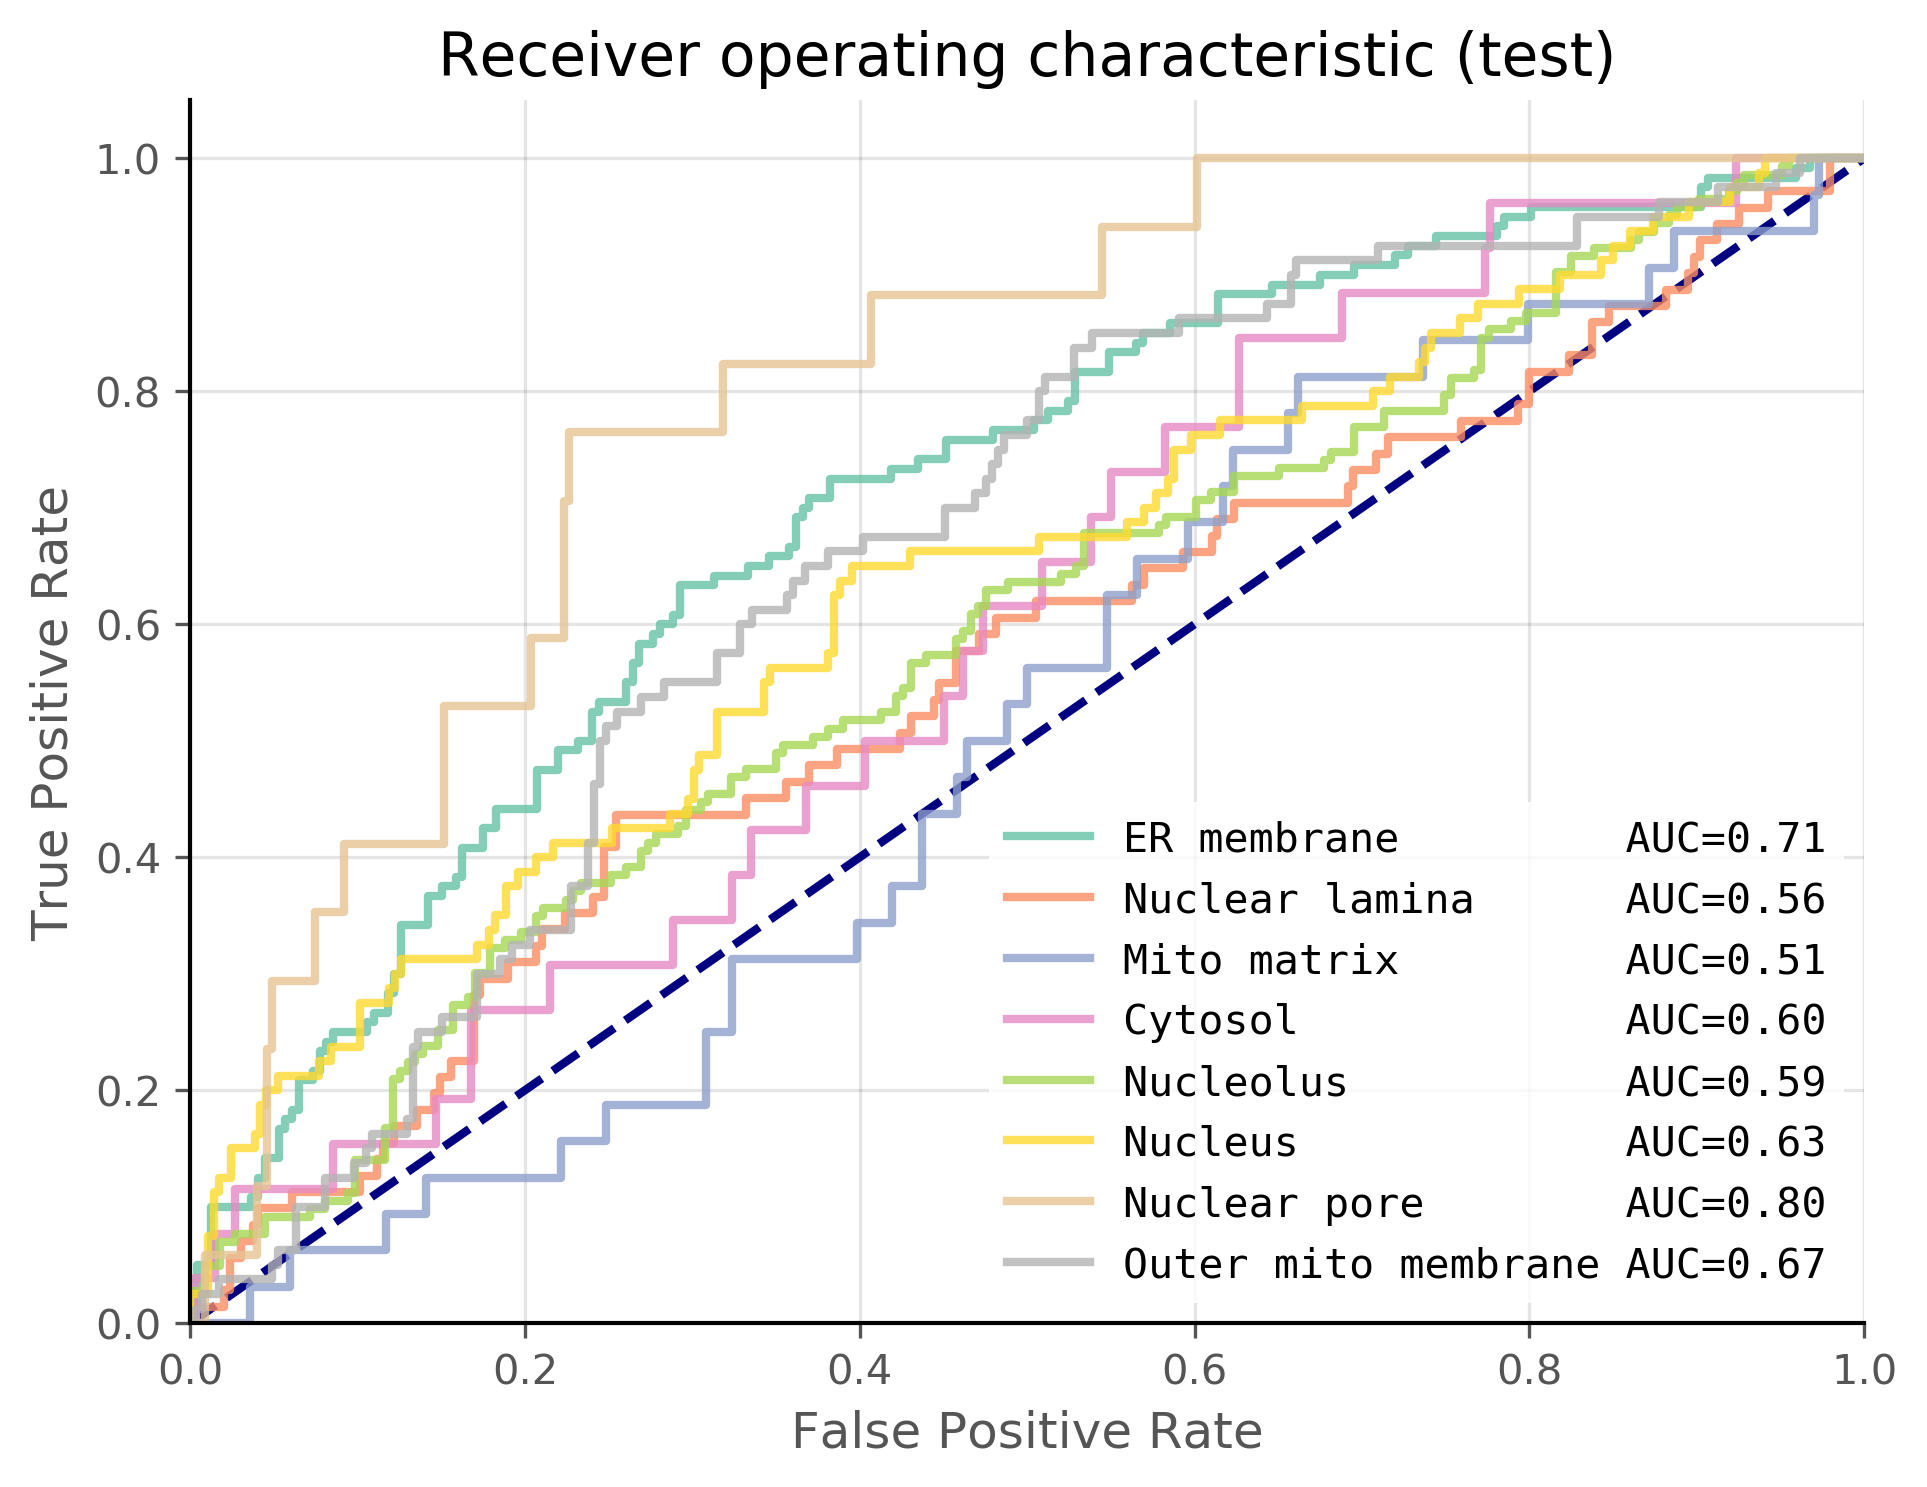

In [43]:
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(lstm_test_dataset.compartments, deep_rna_gru_test_compartment_perf)},
    title="Receiver operating characteristic (test)",
)